# Binning
- 多输出决策树的最优分布分箱
- 信噪比分箱
- 基于分位数分箱
- 用correlation matrix寻找significant feature

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
import pandas as pd
import numpy as np


In [3]:
data = pd.read_csv('../data/curated/combined_data_div.csv')

In [4]:
data.columns

Index(['PtAge', 'WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT',
       'RDW-SD',
       ...
       'HFLC1_div_HFLC2', 'HFLC1_div_NRBC#', 'HFLC1_div_NRBC%',
       'HFLC2_div_NRBC#', 'HFLC2_div_NRBC%', 'NRBC#_div_NRBC%', 'FYZ-IgM',
       '甲流', 'Diagnosis', 'diagnosis_tokenized'],
      dtype='object', length=532)

### 1. 多分类decision tree分箱

In [5]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

def optimal_binning_boundary(x: pd.Series, y: pd.DataFrame, nan: float = -999.) -> list:
    '''
    利用多输出决策树获得最优分箱的边界值列表，并将异常值单独分类
    '''
    # 定义异常值的标准
    z = np.abs((x - x.mean()) / x.std())
    outlier_idx = z > 4

    # 保留原始x的值用于后续分箱
    original_x = x.copy()

    # 用nan替换异常值
    x[outlier_idx] = nan

    # 多输出决策树分箱
    boundary = []  
    x = x.fillna(nan).values.reshape(-1, 1)
    y = y.values

    # 使用多输出决策树
    clf = MultiOutputClassifier(DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=6, min_samples_leaf=0.05))
    clf.fit(x, y)

    # 提取所有树的阈值
    for estimator in clf.estimators_:
        thresholds = estimator.tree_.threshold
        thresholds = thresholds[thresholds != -2]
        boundary.extend(thresholds)

    boundary = list(set(boundary))  # 移除重复的阈值
    boundary.sort()

    min_x = original_x.min()
    max_x = original_x.max() + 0.1  
    boundary = [min_x] + boundary + [max_x]

    # 将异常值作为单独的类别
    boundary = [-np.inf] + boundary + [np.inf]

    return boundary

### 2. 基于分位数的分箱

In [6]:
import numpy as np
import pandas as pd

def quantile_binning(x: pd.Series, num_bins: int, nan: float = -999.) -> pd.Series:
    '''
    使用基于分位数的方法对数据进行分箱。
    :param x: 要分箱的 Pandas Series。
    :param num_bins: 分箱的数量。
    :param nan: 用于表示异常值的数值。
    :return: 分箱后的数据。
    '''
    # 定义异常值的标准
    z = np.abs((x - x.mean()) / x.std())
    outlier_idx = z > 4

    # 将异常值替换为 nan
    x = x.copy()
    x[outlier_idx] = nan

    # 使用 qcut 进行分箱
    # labels=False 会返回每个数据点所属的桶的编号而不是范围
    return pd.qcut(x, q=num_bins, labels=False, duplicates='drop')


### 3. 基于信噪比分箱

In [7]:
def snr_based_binning(x: pd.Series, y: pd.Series, num_bins: int) -> list:
    '''
    根据信号噪声比（SNR）进行分箱。
    :param x: 要分箱的 Pandas Series。
    :param y: 目标变量。
    :param num_bins: 分箱的数量。
    :return: 分箱边界的列表。
    '''
    # 初始化分箱边界列表
    boundaries = np.linspace(x.min(), x.max(), num_bins + 1)

    def calculate_snr(boundaries):
        # 计算每个分箱的 SNR
        snr_list = []
        for i in range(len(boundaries) - 1):
            bin_indices = (x >= boundaries[i]) & (x < boundaries[i + 1])
            bin_values = y[bin_indices]
            if len(bin_values) > 1:
                signal = bin_values.mean()
                noise = bin_values.std(ddof=0)
                snr = signal / noise if noise != 0 else 0
                snr_list.append(snr)
            else:
                snr_list.append(0)
        return np.mean(snr_list)

    # 优化分箱边界
    best_snr = calculate_snr(boundaries)
    best_boundaries = boundaries.copy()

    for _ in range(100):  # 迭代次数可以调整
        new_boundaries = np.random.uniform(x.min(), x.max(), num_bins - 1)
        new_boundaries = np.sort(np.concatenate(([x.min()], new_boundaries, [x.max()])))
        new_snr = calculate_snr(new_boundaries)
        if new_snr > best_snr:
            best_snr = new_snr
            best_boundaries = new_boundaries
    

    return best_boundaries.tolist()


In [8]:
X = data.drop(columns=['FYZ-IgM',
       '甲流', 'Diagnosis', 'diagnosis_tokenized'])
y = data[['FYZ-IgM',
       '甲流']]
# change flout in y to int
y = y.astype(int)
diag = data['diagnosis_tokenized']

In [9]:
tfidf = TfidfVectorizer(max_features=100)  # for example, consider top 100 features
X_tfidf = tfidf.fit_transform(diag).toarray()

# Convert to DataFrame for easier handling
X_tfidf = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())

### Find significant features

In [10]:
X_bin = X.copy()

In [34]:
# 计算相关系数矩阵
corr_matrix = X_bin.corr()

# 查看相关系数
print(corr_matrix.head())


          PtAge       WBC       RBC       HGB       HCT       MCV       MCH  \
PtAge  1.000000 -0.087001 -0.181297  0.004726 -0.033482  0.266132  0.288174   
WBC   -0.087001  1.000000  0.107986  0.066586  0.070142 -0.055449 -0.037392   
RBC   -0.181297  0.107986  1.000000  0.784269  0.832684 -0.207212 -0.119999   
HGB    0.004726  0.066586  0.784269  1.000000  0.945726  0.282823  0.387425   
HCT   -0.033482  0.070142  0.832684  0.945726  1.000000  0.242635  0.288986   

           MCHC       PLT    RDW-SD  ...  CRP_div_HFLC1  CRP_div_HFLC2  \
PtAge  0.161946 -0.213259  0.188119  ...       0.360402       0.326283   
WBC    0.015386  0.351628 -0.017039  ...      -0.050125       0.077336   
RBC    0.053630  0.025047 -0.317817  ...       0.037057       0.069477   
HGB    0.387492 -0.130535 -0.171746  ...       0.163636       0.174294   
HCT    0.207352 -0.109324 -0.151297  ...       0.139973       0.161078   

       CRP_div_NRBC#  CRP_div_NRBC%  HFLC1_div_HFLC2  HFLC1_div_NRBC#  \
PtAge  

KeyboardInterrupt: 

In [12]:
feature_columns = X_bin.columns
label_columns = y.columns

significant_features = {label: [] for label in label_columns}

df = pd.concat([X_bin, y], axis=1)

for label in label_columns:
    group1 = df[df[label] == 1]  
    group2 = df[df[label] == 0]  

    for feature in feature_columns:
        f_value, p_value = stats.f_oneway(group1[feature], group2[feature])
        if p_value < 0.05:
            # print(f"Feature '{feature}' shows significant difference for label '{label}' (p-value: {p_value})")
            significant_features[label].append(feature)

In [13]:
significant_features_union = set().union(*significant_features.values())
# save significant features to csv
pd.DataFrame(significant_features_union).to_csv('../data/curated/significant_features.csv')


### Mutual information

In [14]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = np.zeros((X_bin.shape[1], y.shape[1]))  # 初始化互信息分数矩阵

for i in range(y.shape[1]):
    mi_scores[:, i] = mutual_info_classif(X_bin, y.iloc[:, i])

KeyboardInterrupt: 

In [ ]:
# 设置相关性阈值
threshold = 0.7

# 找到高度相关的特征对
high_corr = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[j]
            high_corr.add(colname)


### 用决策树来做数据分箱

PtAge
[-inf, 0.3333333333333333, 13.5, 17.5, 19.5, 26.5, 27.197924613952637, 33.5, 49.5, 65.5, 97.1, inf]
PtAge
4.0    1716
7.0    1368
1.0    1124
2.0    1102
6.0    1064
3.0     622
9.0     401
8.0     363
5.0     206
0.0       5
Name: count, dtype: int64
-----------------------
WBC
[-inf, 1e-08, 4.444999933242798, 7.414999961853027, 7.894999980926514, 8.444999694824219, 9.994999885559082, 11.045000076293945, 12.760000228881836, 13.404999732971191, 50.89, inf]
WBC
2.0    3580
5.0    1082
1.0     834
3.0     555
4.0     497
6.0     452
9.0     418
7.0     417
8.0      92
0.0      44
Name: count, dtype: int64
-----------------------
RBC
[-inf, 1e-08, 3.9350000619888306, 4.164999961853027, 4.444999933242798, 4.515000104904175, 4.575000047683716, 4.805000066757202, 4.9649999141693115, 4.994999885559082, 5.0950000286102295, 7.449999999999999, inf]
RBC
10.0    1569
3.0     1488
6.0     1445
7.0      880
2.0      669
9.0      462
4.0      438
1.0      427
5.0      402
8.0      165
0.0      

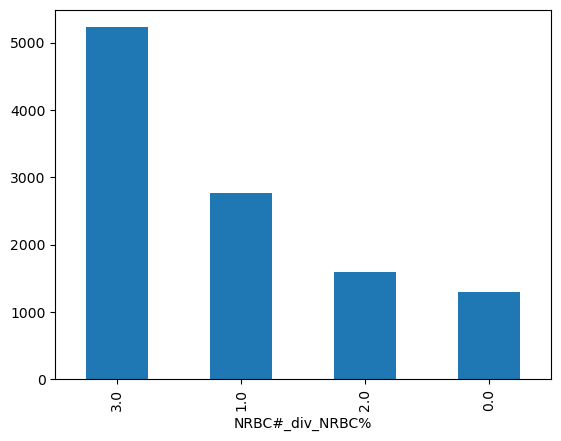

In [15]:
X_bin = X.copy()

# for 分位数分箱
# num_bins = 4

# for i in range(len(X_bin.columns)):
#     X_bin.iloc[:,i] = quantile_binning(X_bin.iloc[:,i], num_bins)    

# 决策树分箱
for i in range(len(X_bin.columns)):
    print(X_bin.columns[i])
    boundary = optimal_binning_boundary(X_bin.iloc[:,i], y)
    print(boundary)
    
    X_bin.iloc[:,i] = pd.cut(X_bin.iloc[:,i], bins=boundary, labels=False, include_lowest=True)
    print(X_bin.iloc[:,i].value_counts())
    print('-----------------------')

# # 信噪比

# num_bins = 5
# for i in range(len(X_bin.columns)):
#     print(X_bin.columns[i])
#     boundaries = snr_based_binning(X_bin.iloc[:,i], y.sum(axis=1) > 0, num_bins) 
#     print(boundaries)
    

    # X_bin.iloc[:,i] = pd.cut(X_bin.iloc[:,i], bins=boundaries, labels=False, include_lowest=True)
    # print(X_bin.iloc[:,i].value_counts())
    # print('-----------------------')

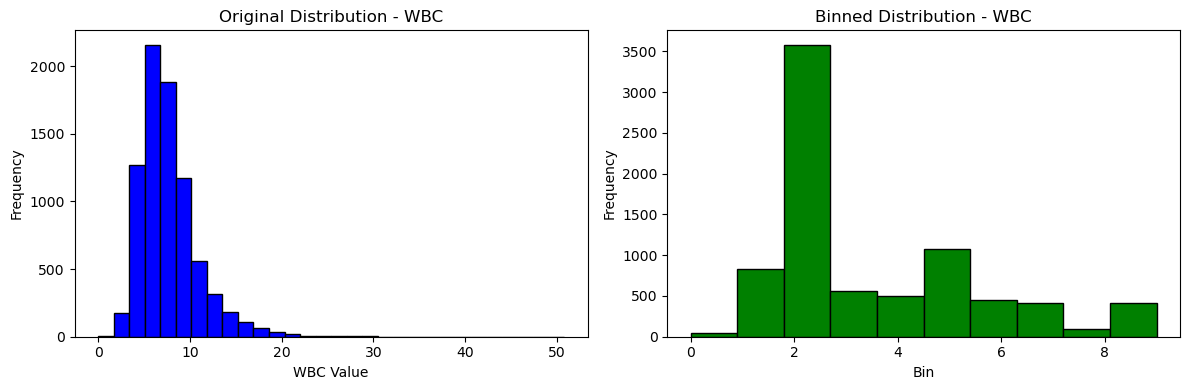

In [33]:
import matplotlib.pyplot as plt
x_vis = X.copy()
# Visualize original distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(x_vis['WBC'], bins=30, color='blue', edgecolor='black')
plt.title('Original Distribution - WBC')
plt.xlabel('WBC Value')
plt.ylabel('Frequency')

# Perform binning
boundary = optimal_binning_boundary(x_vis['WBC'], y)
x_vis['WBC'] = pd.cut(x_vis['WBC'], bins=boundary, labels=False, include_lowest=True)

plt.subplot(1, 2, 2)
plt.hist(x_vis['WBC'], bins=len(set(x_vis['WBC'])), color='green', edgecolor='black')
plt.title('Binned Distribution - WBC')
plt.xlabel('Bin')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [16]:
X_bin.to_csv('../data/curated/combined_data_div_binned.csv', index=False)
# X_reduced.to_csv('../data/curated/combined_data_div_binned_reduced.csv', index=False)
y.to_csv('../data/curated/combined_label.csv', index=False)

### 简单检验

In [17]:
# build a multioutput classifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_bin, y, test_size=0.2, random_state=42)

forest = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X_train, y_train)
y_pred = multi_target_forest.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.56      0.68       459
           1       0.62      0.47      0.54       522

   micro avg       0.73      0.51      0.60       981
   macro avg       0.75      0.52      0.61       981
weighted avg       0.74      0.51      0.60       981
 samples avg       0.32      0.31      0.31       981



/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
label_names = ['FYZ-IgM', '甲流']

for i, l in enumerate(label_names):
    print(f"Performance for label: {l}")
    
    # 提取每个标签的预测和真实值
    y_pred_label = y_pred[:, i]
    y_true_label = y_test[l].values

    # 计算性能指标
    accuracy = accuracy_score(y_true_label, y_pred_label)
    precision = precision_score(y_true_label, y_pred_label)
    recall = recall_score(y_true_label, y_pred_label)
    f1 = f1_score(y_true_label, y_pred_label)

    # 打印性能指标
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}\n")

Performance for label: FYZ-IgM
  Accuracy: 0.8495
  Precision: 0.8712
  Recall: 0.5599
  F1 Score: 0.6817

Performance for label: 甲流
  Accuracy: 0.7342
  Precision: 0.6244
  Recall: 0.4713
  F1 Score: 0.5371

